In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
%matplotlib inline

df = pd.read_csv('./International students Time management data.csv')
df2 = pd.read_csv('./Sheet2.csv')
df.head()

,Number,Age,Gender,Nationality,Program,Course,English,Academic,Attendance,6,...,8,9,10,11,12,13,14,15,16,17
0,1,31-35,M,Korea,PM,Social Sciences and Humanities,60%~70%,NaN,S0,Disagree,...,Strong Agree,Neither,Agree,Neither,Disagree,Strong Disagree,Strong Agree,Neither,Disagree,Agree
1,2,26-30,M,China,PM,Science and engineering,60%~70%,50%~59%,S3,Strong Agree,...,Neither,Disagree,Agree,Neither,Disagree,Strong Disagree,Neither,Agree,Neither,Disagree
2,3,26-30,M,Kenya,PM,Business,60%~70%,NaN,S0,Disagree,...,Agree,Disagree,Agree,Agree,Disagree,Strong Disagree,Disagree,Strong Agree,Strong Agree,Disagree
3,4,21-25,M,Vietnam,PM,Law/Legal studies,60%~70%,60%~70%,S0,Disagree,...,Agree,Agree,Disagree,Agree,Neither,Neither,Neither,Neither,Disagree,Agree
4,5,21-25,M,China,PM,Business,60%~70%,50%~59%,S1,Neither,...,Neither,Neither,Disagree,Neither,Neither,Neither,Neither,Disagree,Neither,Agree


In [2]:
# As shown in the header, none of the variables is directly quantitative in this survey
# Check the data size
num_rows = df.shape[0] #Provide the number of rows in the dataset, know how many survey respondents
num_cols = df.shape[1] #Provide the number of columns in the dataset

print(num_rows)
print(num_cols)

125
21


{'9', 'Attendance', 'English', '14', '8', '16', '17', '11', '12', '6', 'Academic', '10'}


<Figure size 432x288 with 0 Axes>

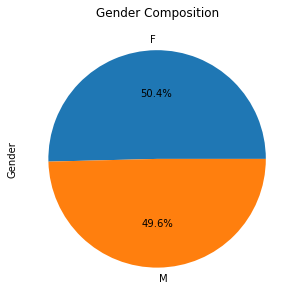

<Figure size 432x288 with 0 Axes>

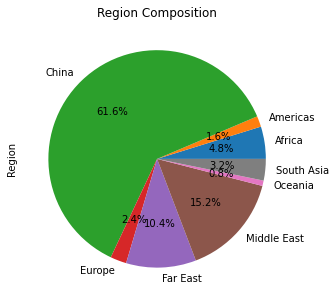

In [3]:
with_nulls = set(df.columns[df.isnull().mean()>0]) #Provide a set of columns with any missing values.
print(with_nulls)


def df_plot(column_str,rot_angle,plt_style):
    '''
    INPUT
    column_str - string, string that specifies the column name in the pre-loaded pandas dataframe of the survey df
    rot_angle - int, angle of rotation
    plt_style - string, plot the group data into pie chart or bar chart
    
    OUTPUT
    N/A - the plotting action is completed within the class, no variable to output 
    '''
    if plt_style == 'pie':
        result_pie = df.groupby([column_str]).size() 
        df_pie = pd.DataFrame({column_str:result_pie.values},index=  result_pie.index)
        plt.figure()
        plt_pie = df_pie.plot.pie(y=column_str, figsize=(5, 5),autopct='%1.1f%%',legend=False)
        #plt_bar = sns.barplot(x = result_bar.index, y = result_bar.values) 
        plt.title(column_str+" Composition"); 

        for item in plt_pie.get_xticklabels():
            item.set_rotation(rot_angle)
    
    elif plt_style == 'bar':
        result_bar = df.groupby([column_str]).size() 
        plt.figure()
        plt_bar = sns.barplot(x = result_bar.index, y = result_bar.values) 
        plt.title(column_str+" Composition"); 

        for item in plt_bar.get_xticklabels():
            item.set_rotation(rot_angle)
        

df_plot('Gender',0,'pie')      

# a look-up dictionary that corresponds one or more countries to a region 
nat_dict = {
    'China': 'China',
    'Far East': ['Korea', 'Vietnam', 'Singapore', 'Malaysia','Thailand', 'Indonesia'],
    'Middle East': ['Saudi Arabia', 'Oman', 'Jordan', 'Georgia', 'Turkey','Kuwait', 'Qatar'],
    'South Asia': ['India', 'Pakistan'],
    'Americas': ['Trinidad and Tobago', 'Colombia'],
    'Europe': ['Portugal', 'UK', 'Ukraine'],
    'Africa': ['Kenya', 'Tanzania', 'Zimbabwe', 'Gongo'],
    'Oceania': 'OCEAN'
}

def nat_classifier(nat_str): 
    '''
    INPUT
    nat_str - string, country of citizenship of the each of the individual survey respondents 

    OUTPUT
    region_str - string, region where a specific country belongs to. Mapping is defined in the dictionary nat_dict
    '''
    region_str = None
    for key in nat_dict: 
        if nat_str in nat_dict[key]:
            region_str = key
            return region_str    

    
df['Region']  = df.loc[:,'Nationality'].apply(nat_classifier)  

df_plot('Region',0,'pie')   




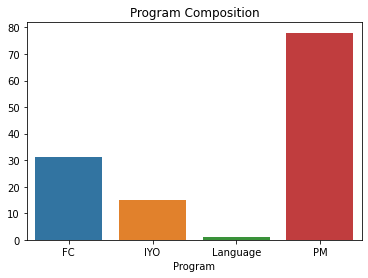

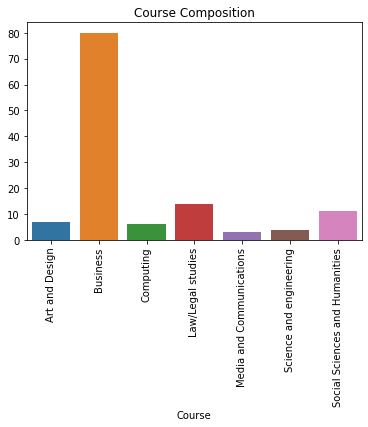

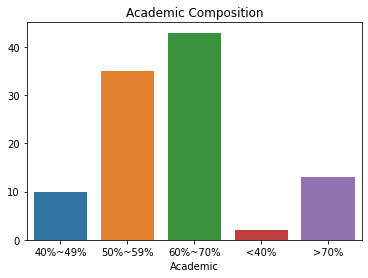

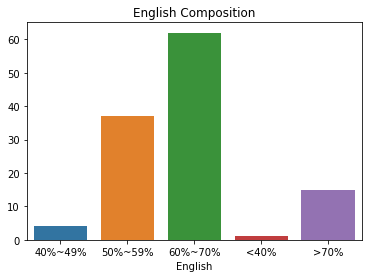

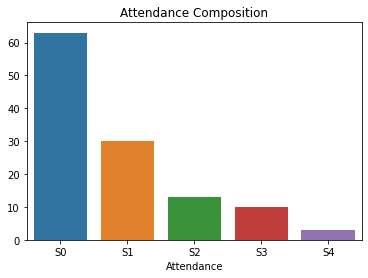

In [4]:

df_plot('Program',0,'bar')
df_plot('Course',90,'bar')
df_plot('Academic',0,'bar')
df_plot('English',0,'bar')
df_plot('Attendance',0,'bar')



In [5]:
def grade_pass_label(grade_num):
    '''
    INPUT
    grade_num - float, a numerical grade range

    OUTPUT
    1/0 - output 1 if the grade is passable, output 0 if failed
    '''
    grade_str = str(grade_num)
    if grade_str in (">70%","60%~70%"):
        return 1
    else:
        return 0

df['Aca'] = df['Academic'].apply(grade_pass_label)


def binary_diff(label_str,column_str):
    '''
    INPUT
    label_str - string, a course grade that has been labeled with pass/fail  
    column_str - string, specific name of the column in the dataframe
    OUTPUT
    comp_df - a dataframe to compare the pass/fail across the control groups
    '''
    s1_perc = df.loc[df[label_str] == 1,column_str].value_counts()/df.loc[df[label_str] == 1,column_str].value_counts().sum() 
    s0_perc = df.loc[df[label_str] == 0,column_str].value_counts()/df.loc[df[label_str] == 0,column_str].value_counts().sum() 
    
    for key in s0_perc.index:
        if key not in s1_perc.index:
            s1_perc.loc[key] = 0
    
    for key in s1_perc.index:
        if key not in s0_perc.index:
            s0_perc.loc[key] = 0
    
    comp_df = pd.merge(s1_perc, s0_perc, left_index=True, right_index=True)
    comp_df.columns = [label_str+'1_perc', label_str+'0_perc']
    comp_df['Diff_'+label_str+'_On_'+column_str] = comp_df[label_str+'1_perc'] - comp_df[label_str+'0_perc']
 
    return comp_df
    
comp_df = binary_diff('Aca','Age')
comp_df.style.bar(subset=['Diff_'+'Aca'+'_On_'+'Age'], align='mid', color=['#d65f5f', '#5fba7d'])

,Aca1_perc,Aca0_perc,Diff_Aca_On_Age
21-25,0.482143,0.507246,-0.025104
18-20,0.357143,0.231884,0.125259
<18,0.089286,0.014493,0.074793
26-30,0.071429,0.115942,-0.044513
31-35,0.000000,0.072464,-0.072464
>36,0.000000,0.057971,-0.057971


In [6]:
df['En'] = df['English'].apply(grade_pass_label)

comp_df2 = binary_diff('En','Age')
comp_df2.style.bar(subset=['Diff_'+'En'+'_On_'+'Age'], align='mid', color=['#d65f5f', '#5fba7d'])


,En1_perc,En0_perc,Diff_En_On_Age
21-25,0.428571,0.604167,-0.175595
18-20,0.363636,0.166667,0.196970
26-30,0.103896,0.083333,0.020563
<18,0.077922,0.000000,0.077922
31-35,0.012987,0.083333,-0.070346
>36,0.012987,0.062500,-0.049513


In [7]:
comp_df3 = binary_diff('Aca','Program')
comp_df3.style.bar(subset=['Diff_'+'Aca'+'_On_'+'Program'], align='mid', color=['#d65f5f', '#5fba7d'])

,Aca1_perc,Aca0_perc,Diff_Aca_On_Program
PM,0.535714,0.695652,-0.159938
FC,0.321429,0.188406,0.133023
IYO,0.142857,0.101449,0.041408
Language,0.000000,0.014493,-0.014493


In [8]:
comp_df4 = binary_diff('En','Program')
comp_df4.style.bar(subset=['Diff_'+'En'+'_On_'+'Program'], align='mid', color=['#d65f5f', '#5fba7d'])

,En1_perc,En0_perc,Diff_En_On_Program
PM,0.506494,0.812500,-0.306006
FC,0.350649,0.083333,0.267316
IYO,0.142857,0.083333,0.059524
Language,0.000000,0.020833,-0.020833


                            OLS Regression Results                            
Dep. Variable:               Academic   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9954
Date:                Mon, 15 Feb 2021   Prob (F-statistic):              0.458
Time:                        16:17:25   Log-Likelihood:                -272.99
No. Observations:                 125   AIC:                             572.0
Df Residuals:                     112   BIC:                             608.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.8325      1.422      4.804      0.0

C:\Users\usr295\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


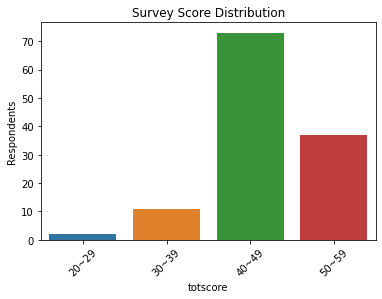

<Figure size 432x288 with 0 Axes>

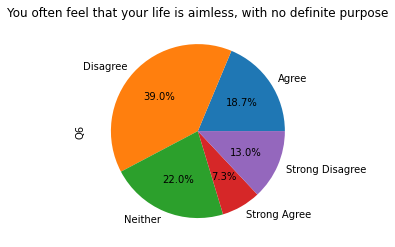

<Figure size 432x288 with 0 Axes>

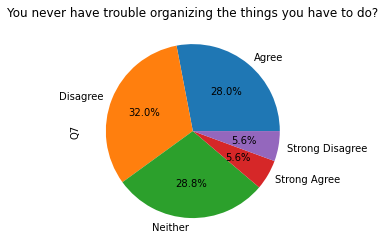

<Figure size 432x288 with 0 Axes>

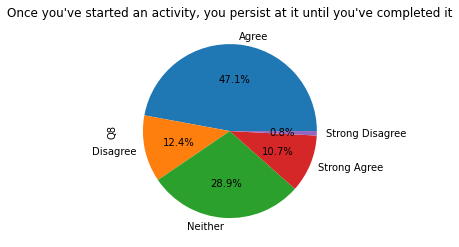

<Figure size 432x288 with 0 Axes>

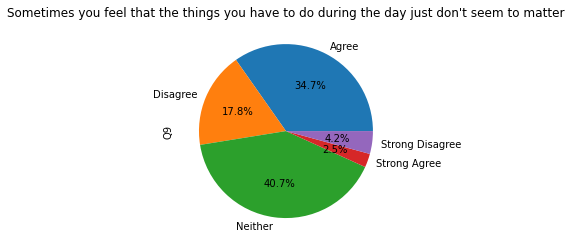

<Figure size 432x288 with 0 Axes>

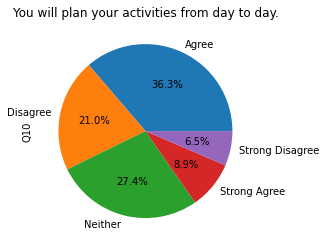

<Figure size 432x288 with 0 Axes>

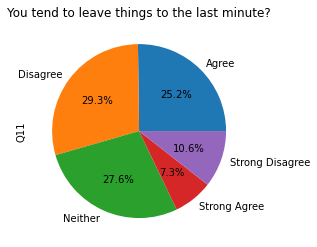

<Figure size 432x288 with 0 Axes>

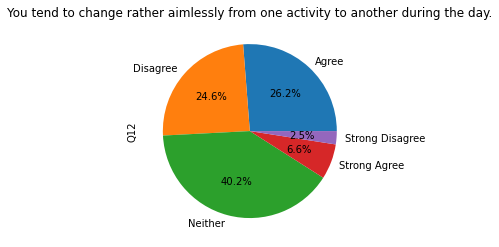

<Figure size 432x288 with 0 Axes>

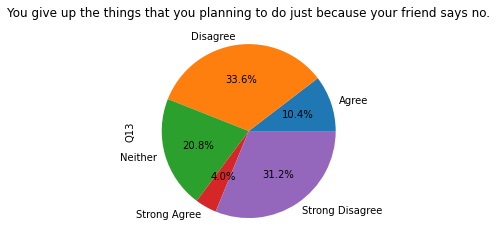

<Figure size 432x288 with 0 Axes>

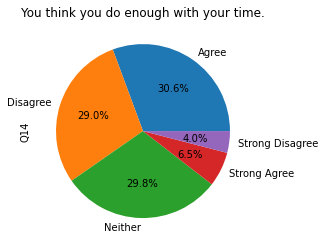

<Figure size 432x288 with 0 Axes>

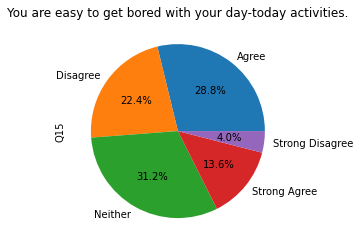

<Figure size 432x288 with 0 Axes>

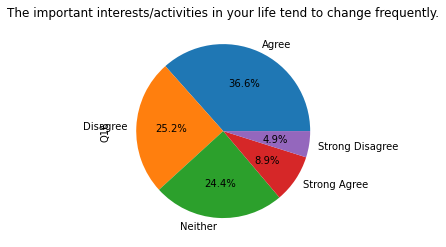

<Figure size 432x288 with 0 Axes>

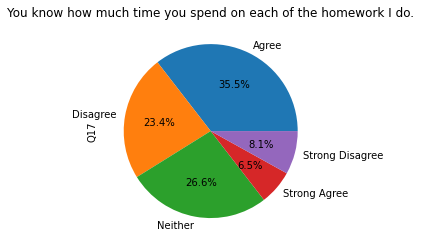

In [9]:
agreescore_dict = {
    'Strong Agree': 1,
    'Agree': 2,
    'Neither': 3,
    'Disagree': 4,
    'Strong Disagree': 5,
}

def Qscore(Agr_Str,Qnum):
    '''
    INPUT
    Agr_Str - string, ranging from "strongly disagree" to "strongly agree"
    Qnum - int, the column index
    OUTPUT
    agreescore - int, 1~5 mapping according to the dictionary agreescore_dict
    '''
    def Rev5(Score,Qnum):
        '''
        INPUT
        Score - int, 1~5
        Qnum -  int, the column index, in certain columns the score should be flipped from asceding order to desceding order
        OUTPUT
        Score - int, 1~5
        '''
        if Qnum in (7,8,10,14,17):
            return 6-Score
        else:
            return Score
        
    agreescore = 0
    for key in agreescore_dict: 
        if Agr_Str == key:
            agreescore = agreescore_dict[key]
            agreescore = Rev5(agreescore,Qnum)           
    return  agreescore 


for Qnum in range(6, 18):
    df_score_temp = df.loc[:,str(Qnum)].apply(Qscore,Qnum=Qnum)
    if Qnum == 6:
        df_score_total = df_score_temp
    else:
        df_score_total = pd.concat([df_score_total, df_score_temp],axis = 1)
        
grade_dict = {
    '>70%': 7,
    '<40%': 3,
    '60%~70%': 6,
    '50%~59%': 5,
    '40%~49%': 4,
}        
        
def grade_conv(grade_num):
    '''
    INPUT
    grade_num - float, a numerical grade range

    OUTPUT
    scaled_grade - int, mapping the grade according to the dictionary grade_dict
    '''
    grade_str = str(grade_num)
    scaled_grade = 0
    for key in grade_dict:
        if grade_str == key:
            scaled_grade = grade_dict[key]
    return scaled_grade

X_reg = df_score_total[df_score_total.columns[0:12]] 


df_score_total['Academic'] = df['Academic'].apply(grade_conv)        
df_score_total['English'] = df['English'].apply(grade_conv)  

y_reg1 = df_score_total['Academic'] 
y_reg2 = df_score_total['English']


#plt.figure(figsize=(20,10))
#sns.heatmap(corr_results, annot=True,cmap="YlGnBu")

X_reg2 = sm.add_constant(X_reg)
est_a = sm.OLS(y_reg1, X_reg2)
est_a2 = est_a.fit()
print(est_a2.summary())

est_e = sm.OLS(y_reg2, X_reg2)
est_e2 = est_e.fit()
print(est_e2.summary())

rescore_dict = {
    '0~9': range(0,10),
    '10~19': range(10,20),
    '20~29': range(20,30),
    '30~39': range(30,40),
    '40~49': range(40,50),
    '50~59': range(50,60),
}
        
def rescore_classifier(score):
    '''
    INPUT
    score - float, a numerical score of each survey respondent added up from the survey questions

    OUTPUT
    rescore - string, assign the survey score to range groups defined in the dictionary rescore_dict
    '''
    rescore = None
    for key in rescore_dict: 
        if score in rescore_dict[key]:
            rescore = key
            return rescore    
        


df['totscore']= df_score_total.sum(axis=1).apply(rescore_classifier)
result_rescore = df.groupby(['totscore']).size() 

plt.figure()
plt_score = sns.barplot(x = result_rescore.index, y = result_rescore.values) 
plt.title("Survey Score Distribution"); 
plt.ylabel("Respondents"); 

for item in plt_score.get_xticklabels():
    item.set_rotation(45)


def pie_survey(Qnum,Q_shift):
    result_Q = df.groupby([str(Qnum)]).size() 
    df_Q = pd.DataFrame({'Q'+str(Qnum):result_Q.values},index=result_Q.index)
    plt.figure()
    df_Q.plot.pie(y='Q'+str(Qnum),autopct='%1.1f%%', legend = False)
    plt.title(df2.loc[Qnum-Q_shift, 'Questions']);

for Qnum in range(6, 18):
    pie_survey(Qnum,5)


In [10]:
results_EngAtt = df.groupby(['English', 'Attendance']).size().unstack(fill_value=0)
results_AcaAtt = df.groupby(['Academic', 'Attendance']).size().unstack(fill_value=0)

results_AcaAtt

Attendance,S0,S1,S2,S3,S4
Academic,,,,,
40%~49%,2,3,0,5,0
50%~59%,12,13,6,3,0
60%~70%,26,9,6,1,1
<40%,0,0,0,1,1
>70%,7,4,1,0,1


In [11]:
results_EngAtt

Attendance,S0,S1,S2,S3,S4
English,,,,,
40%~49%,1,1,0,2,0
50%~59%,15,12,6,3,0
60%~70%,37,14,5,5,1
<40%,0,0,0,0,1
>70%,9,3,2,0,1


In [12]:
corr_results=df_score_total.corr(method='pearson')


corr_aca = corr_results.loc['6':'17','Academic']
corr_eng = corr_results.loc['6':'17','English']
comp_corr = pd.merge(corr_aca, corr_eng, left_index=True, right_index=True)
comp_corr.columns = ['Academic Correlation', 'English Correlation']
comp_corr.style.bar(subset=['Academic Correlation','English Correlation'], align='mid', color=['#d65f5f', '#5fba7d'])

,Academic Correlation,English Correlation
6,0.054573,0.052319
7,-0.066422,0.061556
8,-0.044167,0.025390
9,-0.102409,0.106639
10,0.008597,0.031200
11,0.021322,0.094698
12,0.054801,0.112336
13,-0.092960,-0.022365
14,0.021128,0.133571
15,-0.188326,-0.186270
